In [17]:
# Data Loading & first Pre-Processing steps
import numpy as np

#Read data

X = []
samples_x = []

f = open("genotypes.csv","r")

for i,line in enumerate(f):
    if(i == 0):
       continue
    
    sv = line.strip().split(",")
    samples_x.append(sv[0])
    
    row = []
    for element in sv[1:]:
        row.append(element)
    X.append(row)
    
f.close()

X = np.array(X)
samples_x = np.array(samples_x)

y = []
samples_y = []

f = open("phenotype_values.csv","r")

for i,line in enumerate(f):
    if(i == 0):
       continue
    sv = line.strip().split(",")
    samples_y.append(sv[0])
    y.append(float(sv[1]))
    
f.close()

y = np.array(y)
samples_y = np.array(samples_y)

#Replace "?" with np.nan
X = np.where(X == "?", np.nan, X)

# Match genotypes with phenotype values knn
truth_table = (samples_x[:,np.newaxis]==samples_y)
ind = np.where(truth_table==True)

samples_x = samples_x[ind[0]]
samples_y = samples_y[ind[1]]

X = X[ind[0],:]
y = y[ind[1]]

# Split into train data and validation data

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=73)

In [18]:
#Encode nucleotide values

for j in range (X_train.shape[1]):
    
    values, counts = np.unique(X_train[:,j], return_counts=True)
    values = values[:2]
    counts = counts[:2]

    X_train[:,j] = np.where(X_train[:,j] == values[np.argmax(counts)], 0, X_train[:,j])
    X_train[:,j] = np.where(X_train[:,j] == values[np.argmin(counts)], 2, X_train[:,j])
    #Encode validation data based on the known data
    X_val[:,j] = np.where(X_val[:,j] == values[np.argmax(counts)], 0, X_val[:,j]) 
    X_val[:,j] = np.where(X_val[:,j] == values[np.argmin(counts)], 2, X_val[:,j])
    
#Convert array from string to float
X_train = X_train.astype(np.float_)
X_val = X_val.astype(np.float_)

In [19]:
#Impute missing values on training data with KNNImputer
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer (missing_values=np.nan, n_neighbors=3, weights="distance")
X_train = knn_imputer.fit_transform(X_train)

for i in range (X_val.shape[0]):
    x = X_val[i]
    x.shape = (1,5000)
    X_valr = knn_imputer.fit_transform(np.append(x,X_train,axis = 0))
    [val_data, R] = np.split(X_valr,[1],axis = 0)
    while i == 0:
        val = val_data
        break
    while i >= 1:
        val = np.append(val,val_data,axis = 0)
        break

for j in range (X_train.shape[1]):
    X_train[:,j] = np.where(X_train[:,j] < 1, 0.0, X_train[:,j])
    X_train[:,j] = np.where(X_train[:,j] >= 1, 2.0, X_train[:,j])
    val[:,j] = np.where(val[:,j] < 1, 0.0, val[:,j])
    val[:,j] = np.where(val[:,j] >= 1, 2.0, val[:,j])
    X_val = val

In [4]:
#PCA was not always used please see the poster for replication

#standardise the data
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
Xn = scaler.fit_transform(X_train)

#compute the covariance matrix on the standardised data
n = Xn.shape[0]
C = 1/(n-1) * np.dot(Xn.T,Xn)

#eigendecompose the matrix  𝐂  into its eigenvalues and eigenvector
import numpy.linalg as linalg
d, V = linalg.eig(C)

#sort the eigenvalues in decreasing order, re-sort the columns of the eigenvector matrix 𝑉  using the indices from the sorting of the eigenvalues
ind = np.argsort(d)[::-1]
d = d[ind]
V = V[:,ind]

Xn1 = np.dot(Xn,V[:,0:750])
X_train = np.array(Xn1,dtype=float)

#calculate how much of the total variance the PCs account for
ratios_variance_explained = d/d.sum()
va = ratios_variance_explained[0:750].sum()

#transform validation data
Xn3_Xval = np.dot(val,V[:,0:750])
X_val = np.array(Xn3_Xval,dtype=float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
###MODELS###

In [ ]:
#KNN Regression k-validation
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics as metrics
import time

K = np.arange(5,26,1)
r2_trainknr = []
r2_valknr = []

start = time.process_time()
for k in K:
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train,y_train)
    knr_predictions_training = knr.predict(X_train)
    knr_predictions_validating = knr.predict(X_val)
    r2_trainingknr = metrics.r2_score(y_train,knr_predictions_training)
    r2_validationknr = metrics.r2_score(y_val,knr_predictions_validating)
    r2_trainknr.append(r2_trainingknr)
    r2_valknr.append(r2_validationknr)

best_k = K[np.argmax(r2_valknr)]
print("Best_k = " + str(best_k))
print("Best R2: %.4f" %np.max(r2_valknr))

delta = (time.process_time()-start)
print("Computation Time: %f s" %delta)

In [ ]:
#ElasticNetCV
from sklearn import linear_model
import sklearn.metrics as metrics
import time


start = time.process_time()
l1r = np.arange(0.1,1.05,0.05)

#ElasticNetCV    
elncv = linear_model.ElasticNetCV(cv = 5, l1_ratio=l1r, max_iter=7000, random_state=73)
elncv.fit(X_train, y_train)
predictions_training = elncv.predict(X_train)
predictions_validating = elncv.predict(X_val)

print("MSE (Train):\t%.2f" % metrics.mean_squared_error(y_train, predictions_training))
print("R2 (Train):\t%.2f" % metrics.r2_score(y_train, predictions_training))
print("MSE (Val):\t%.2f" % metrics.mean_squared_error(y_val, predictions_validating))
print("R2 (Val):\t%.2f" % metrics.r2_score(y_val, predictions_validating))
print("The selected Alpha:\t%.f " %elncv.alpha_)
print("The selected L1-Ration:\t%.f " %elncv.l1_ratio_)

delta = time.process_time() - start
print("Computation Time: %f s" %delta)

In [ ]:
#KNN Regression Model based on split
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics as metrics
import time

start = time.process_time()

knr = KNeighborsRegressor(n_neighbors=7)
knr.fit(X_train,y_train)
knr_predictions_training = knr.predict(X_train)
knr_predictions_validating = knr.predict(X_val)

print("MSE (Train):\t%.2f" % metrics.mean_squared_error(y_train, knr_predictions_training))
print("R2 (Train):\t%.2f" % metrics.r2_score(y_train, knr_predictions_training))
print("MSE (Val):\t%.2f" % metrics.mean_squared_error(y_val, knr_predictions_validating))
print("R2 (Val):\t%.2f" % metrics.r2_score(y_val, knr_predictions_validating))

delta = time.process_time() - start
print("Computation Time: %f s" %delta)

In [20]:
#ElasticNet Model based on split
from sklearn.linear_model import ElasticNet
import sklearn.metrics as metrics
import time

start = time.process_time()

eln =ElasticNet(alpha=0.05792901004687936, l1_ratio=0.25, max_iter=7000, random_state=73)
eln.fit(X_train, y_train)
predictions_training = eln.predict(X_train)
predictions_validating = eln.predict(X_val)

print("MSE (Train):\t%.2f" % metrics.mean_squared_error(y_train, predictions_training))
print("R2 (Train):\t%.2f" % metrics.r2_score(y_train, predictions_training))
print("MSE (Val):\t%.2f" % metrics.mean_squared_error(y_val, predictions_validating))
print("R2 (Val):\t%.2f" % metrics.r2_score(y_val, predictions_validating))

delta = (time.process_time()-start)
print("Computation Time: %f s" %delta)

MSE (Train):	0.65
R2 (Train):	0.94
MSE (Val):	3.41
R2 (Val):	0.66
Computation Time: 837.128813 s


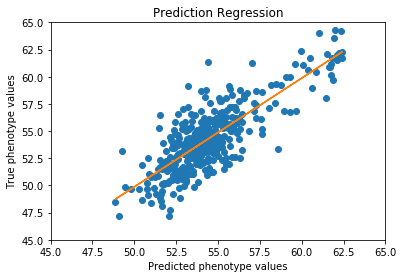

In [38]:
import matplotlib.patches as patches
import numpy as np
import pylab as pl
import sklearn.metrics as metrics
%matplotlib inline

#generate figure
fig = pl.figure()
ax = fig.add_subplot(111)

ax.plot(predictions_validating, y_val, 'o')
ax.set_xlabel("Predicted phenotype values")
ax.set_ylabel("True phenotype values")
#Set axis limits
ax.set_ylim(45,65)
ax.set_xlim(45,65)
ax.set_title("Prediction Regression")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(predictions_validating, y_val, 1)

#add linear regression line to scatterplot 
ax.plot(predictions_validating, m*predictions_validating+b)

In [ ]:
### PREDICTING UNKNOWN

In [6]:
import numpy as np

#Read known genotype values
X_train = []
samples_x_train = []

f = open("genotypes.csv","r")

for i,line in enumerate(f):
    if(i == 0):
        continue
    
    sv = line.strip().split(",")
    samples_x_train.append(sv[0])
    
    row = []
    for element in sv[1:]:
        row.append(element)
    X_train.append(row)
    
f.close()

X_train = np.array(X_train)
samples_x_train = np.array(samples_x_train)

# Read phenotype values

y_train = []
samples_y_train = []

f = open("phenotype_values.csv","r")

for i,line in enumerate(f):
    if(i == 0):
        continue
    sv = line.strip().split(",")
    samples_y_train.append(sv[0])
    y_train.append(float(sv[1]))
    
f.close()

y_train = np.array(y_train)
samples_y_train = np.array(samples_y_train)

#Read unknown genotypes
X_test = []
samples_x_test=[]

fd=open("unknown_genotypes.csv","r")

for i, line in enumerate(fd):
    if(i==0):
        continue
    sv=line.strip().split(",")
    samples_x_test.append(sv[0])
    row=[]
    
    for element in sv[1:]:
        row.append(element)
    X_test.append(row)
    
fd.close()
X_test=np.array(X_test)
samples_x_test=np.array(samples_x_test)

#Replace "?" with np.nan
X_train = np.where(X_train == "?", np.nan, X_train)
X_test = np.where(X_test == "?", np.nan, X_test)

#Match genotypes with phenotype values
truth_table = (samples_x_train[:,np.newaxis]==samples_y_train)
ind = np.where(truth_table==True)

samples_x_train = samples_x_train[ind[0]]
samples_y_train = samples_y_train[ind[1]]

X_train = X_train[ind[0],:]
y_train = y_train[ind[1]]

In [7]:
#Encode nucleotide values
for j in range (X_train.shape[1]):
    
    values, counts = np.unique(X_train[:,j], return_counts=True)
    values=values[:2]
    counts=counts[:2]

    X_train[:,j] = np.where(X_train[:,j] == values[np.argmax(counts)], 0, X_train[:,j])
    X_train[:,j] = np.where(X_train[:,j] == values[np.argmin(counts)], 2, X_train[:,j])
    X_test[:,j] = np.where(X_test[:,j] == values[np.argmax(counts)], 0, X_test[:,j]) #Encode based on the known data
    X_test[:,j] = np.where(X_test[:,j] == values[np.argmin(counts)], 2, X_test[:,j])
    
#Convert array from string to float
X_train = X_train.astype(np.float_)
X_test = X_test.astype(np.float_)

In [8]:
# Impute missing values on training data with KNNImputer

from sklearn.impute import KNNImputer

knn_imputer = KNNImputer (missing_values=np.nan, n_neighbors=3, weights="distance")
X_train = knn_imputer.fit_transform(X_train)

for i in range (X_test.shape[0]):
    x = X_test[i]
    x.shape = (1,5000)
    X_testr = knn_imputer.fit_transform(np.append(x,X_train,axis = 0))
    [test_data, R] = np.split(X_testr,[1],axis = 0)
    while i == 0:
        test = test_data
        break
    while i >= 1:
        test = np.append(test,test_data,axis = 0)
        break

for j in range (X_train.shape[1]):
    X_train[:,j] = np.where(X_train[:,j] < 1, 0.0, X_train[:,j])
    X_train[:,j] = np.where(X_train[:,j] >= 1, 2.0, X_train[:,j])
    test[:,j] = np.where(test[:,j] < 1, 0.0, test[:,j])
    test[:,j] = np.where(test[:,j] >= 1, 2.0, test[:,j])
    X_test = test

In [ ]:
#PCA was not always used please see the poster for replication

#standardise the data
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
Xn = scaler.fit_transform(X_train)

#compute the covariance matrix on the standardised data
n = Xn.shape[0]
C = 1/(n-1) * np.dot(Xn.T,Xn)

#eigendecompose the matrix  𝐂  into its eigenvalues and eigenvector
import numpy.linalg as linalg
d, V = linalg.eig(C)

#sort the eigenvalues in decreasing order, re-sort the columns of the eigenvector matrix 𝑉  using the indices from the sorting of the eigenvalues
ind = np.argsort(d)[::-1]
d = d[ind]
V = V[:,ind]

Xn1 = np.dot(Xn,V[:,0:750])
X_train = np.array(Xn1,dtype=float)

#calculate how much of the total variance the PCs account for
ratios_variance_explained = d/d.sum()
va = ratios_variance_explained[0:750].sum()

#transform test data
Xn3_Xtest = np.dot(test,V[:,0:750])
X_test = np.array(Xn3_Xtest,dtype=float)

In [ ]:
#KNN Regression Model for unknown
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics as metrics
import time

start = time.process_time()

knr = KNeighborsRegressor(n_neighbors=7)
knr.fit(X_train,y_train)
knr_predictions_training = knr.predict(X_train)
knr_predictions_testing = knr.predict(X_test)

print("MSE (Train):\t%.2f" % metrics.mean_squared_error(y_train, knr_predictions_training))
print("EV (Train):\t %.2f" %metrics.explained_variance_score(y_train, knr_predictions_training))
print("MAE (Train):\t %.2f" %metrics.mean_absolute_error(y_train, knr_predictions_training))
print("R2 (Train):\t%.2f" % metrics.r2_score(y_train, knr_predictions_training))

delta = time.process_time() - start
print("Computation Time: %f s" %delta)

In [ ]:
import pandas as pd

df_samples=pd.DataFrame(samples_x_test)
df_y_pred=pd.DataFrame(knr_predictions_testing)
frames=[df_samples,df_y_pred]
df_final=pd.concat(frames, axis=1, join='inner')

df_final.to_csv("y_predictions_knr.csv",index=False,header=False)

In [16]:
#ElasticNet Model for unknown
from sklearn.linear_model import ElasticNet
import sklearn.metrics as metrics
import time

start = time.process_time()

eln = ElasticNet(alpha=0.05792901004687936, l1_ratio=0.25, max_iter=7000)
eln.fit(X_train, y_train)
predictions_training = eln.predict(X_train)
predictions_testing = eln.predict(X_test)

print("MSE (Train):\t%.2f" % metrics.mean_squared_error(y_train, predictions_training))
print("EV (Train):\t %.2f" %metrics.explained_variance_score(y_train,predictions_training))
print("MAE (Train):\t %.2f" %metrics.mean_absolute_error(y_train, predictions_training))
print("R2 (Train):\t%.2f" % metrics.r2_score(y_train, predictions_training))

delta = (time.process_time()-start)
print("Computation Time: %f s" %delta)

MSE (Train):	0.79
EV (Train):	 0.92
MAE (Train):	 0.69
R2 (Train):	0.92
Computation Time: 888.225106 s


In [ ]:
import pandas as pd

df_samples=pd.DataFrame(samples_x_test)
df_y_pred=pd.DataFrame(predictions_testing)
frames=[df_samples,df_y_pred]
df_final=pd.concat(frames, axis=1, join='inner')

df_final.to_csv("y_predictions_eln.csv",index=False,header=False)